# REPRODUCING RESULTS FROM THE HOME ADVANTAGE IN FOOTBALL PAPER

## Introduction

This paper aims at reproducing the study "COVID and Home Advantage in Football: An Analysis of Results and xG Data in European Leagues" by Mathieu Acher. The original study investigates the impact of the COVID-19 pandemic on home advantage in football matches across European leagues. The authors analyze match results, expected goals (xG) and expected Points (xPts) data to assess changes in home advantage before and during the Covid-19 pandemic. Covid-19 has led to the suspension of football matches, the absence of fans in stadiums, and changes in match schedules. The study explores how these factors have influenced home advantage in football matches.

## Data

We collected data from [Understat](https://understat.com/), a website contaning the detailed results, expected Goals and points statistic for teams and players from the biggest football leagues in the world (Ligue 1, la Liga, Serie A,
Bundesliga, EPL, RFPL) from 2014 to nowadays. We collected data from this website thanks to an API that allowed us to get all statistical results from each league and season. The API is really easy to use and retrieves JSON files containing all needed information. Here is an example of a request to collect all results from Ligue 1 for the 2014 season:

```
fixtures = await understat.get_league_results("Ligue_1", 2014)
```
As a result, the API returns this kind of JSON file:

```
[{'id': '6185', 'isResult': True, 'h': {'id': '177', 'title': 'Reims', 'short_title': 'REI'}, 'a': {'id': '161', 'title': 'Paris Saint Germain', 'short_title': 'PSG'}, 'goals': {'h': '2', 'a': '2'}, 'xG': {'h': '1.36787', 'a': '2.65538'}, 'datetime': '2014-08-08 19:30:00', 'forecast': {'w': '0.1036', 'd': '0.195', 'l': '0.7014'}},
{'id': '6186', 'isResult': True, 'h': {'id': '162', 'title': 'SC Bastia', 'short_title': 'BAS'}, 'a': {'id': '164', 'title': 'Marseille', 'short_title': 'MAR'}, 'goals': {'h': '3', 'a': '3'}, 'xG': {'h': '1.39689', 'a': '1.31751'}, 'datetime': '2014-08-09 20:00:00', 'forecast': {'w': '0.3542', 'd': '0.3444', 'l': '0.3014'}}]
```
Those two lines represent results from the 2 first matches of Ligue 1 for the 2014 season. Each line contains the name of the two teams of the match, the result of the match (goals from the home team 'h' and from the away team 'a'), the expected goals of each team, the date of the match and a forecast (sports betting odds).

Here is the download, build, and installation of Understat package in the Colab environment.

In [ ]:
pip install understat

Defaulting to user installation because normal site-packages is not writeable
ERROR: Invalid requirement: 'understat,'
Note: you may need to restart the kernel to use updated packages.


In [26]:
import asyncio
import json
import aiohttp
import numpy as np
import pandas as pd
from understat import Understat
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon, mannwhitneyu
from asyncio.tasks import FIRST_COMPLETED

## HOME ADVANTAGE ?

This first code below aims at reproducing the first table representing differences between points gained at home and away (actual results and xPoints). This table shows the same results than what is obtained in the original paper for both columns. We defined functions to calculate total points gained at home and away and totale expected points home and away. We collected data from each league and each season, at home and away separately and we substracted away results from home results. Results obtained have been rounded to correspond to what is found in the original paper.

This table really seems to show a significant advantage of playing at home. Teams are winning way more points in total (and xPoints too) at home than away for classical seasons (except 2020-2021 season) for all leagues. Low or negative results for points and xPoints gained at home corresponds to the COVID period where stadiums were empty. During this period, teams seem to win way less points and xPoints at home than in the past seasons. Some results seem similar for 2019-2020 season which corresponds to the beginning of the pandemic.  



In [27]:

LEAGUES = ["Ligue_1", "La_liga", "EPL", "Bundesliga", "Serie_A", "RFPL"]
SEASONS = [2014, 2015, 2016, 2017, 2018, 2019, 2020]

def getPoints(liste):
    num_array = np.array(liste)
    pandas_array = pd.DataFrame(num_array[1:], columns=num_array[0])
    col_pts = pandas_array['PTS'].astype(int)
    sum_pts = col_pts.sum()
    return sum_pts

def getXPoints(liste):
    num_array = np.array(liste)
    pandas_array = pd.DataFrame(num_array[1:], columns=num_array[0])
    col_pts = pandas_array['xPTS'].astype(float)
    sum_pts = col_pts.sum()
    return sum_pts

final_df = pd.DataFrame(columns=["League", "Season", "Diff_pts", "Diff_Xpts"])

async with aiohttp.ClientSession() as session:
    understat = Understat(session)
    for league in LEAGUES:
        for season in SEASONS:
            fixtures_dom = await understat.get_league_table(league, season, h_a = "home")
            fixtures_ext = await understat.get_league_table(league, season, h_a = "away")
            diff_pts = getPoints(fixtures_dom) - getPoints(fixtures_ext)
            diff_xpts = round(getXPoints(fixtures_dom) - getXPoints(fixtures_ext))
            final_df = final_df._append({"League": league, "Season": season, "Diff_pts": diff_pts, "Diff_Xpts": diff_xpts}, ignore_index=True)
            #print(f"différence de points en {league} de la saison {season} : {diff_pts}")

final_df

,League,Season,Diff_pts,Diff_Xpts
0,Ligue_1,2014,210,170
1,Ligue_1,2015,144,191
2,Ligue_1,2016,258,195
3,Ligue_1,2017,186,177
4,Ligue_1,2018,174,169
5,Ligue_1,2019,177,120
6,Ligue_1,2020,-3,61
7,La_liga,2014,159,201
8,La_liga,2015,234,173
9,La_liga,2016,213,206


This second code aims at reproducing the plots of the original paper. The plots are representing the evolution of mean gained points (per match) for all seasons from 2014 to 2020. We calculated the mean points won at home and away per year and per league thanks to the *getMeanPerYear* method by adding all points won at home (and away respectively) and dividing by the number of total matches played in the season. We calculated the same way for xPoints home and away. We then used matplotlib in order to plot the results.

We obtained the exact same plot than the original paper for each league. A significant decrease in mean points won at home and a significant increase in mean points won away is shown by our plots for season 2020-2021 (and in 2019-2020 for RFPL), corresponding to the pandemic period.

<ipython-input-28-368449f18510>:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_df = final_df._append({"Season": to_season[season], "result": getMeanPerYear(league, fixtures_dom), "xPoints" : getMeanXPointsPerYear(league, fixtures_dom), "result_away" : getMeanPerYear(league, fixtures_ext), "xPointsAway": getMeanXPointsPerYear(league, fixtures_ext)}, ignore_index=True)


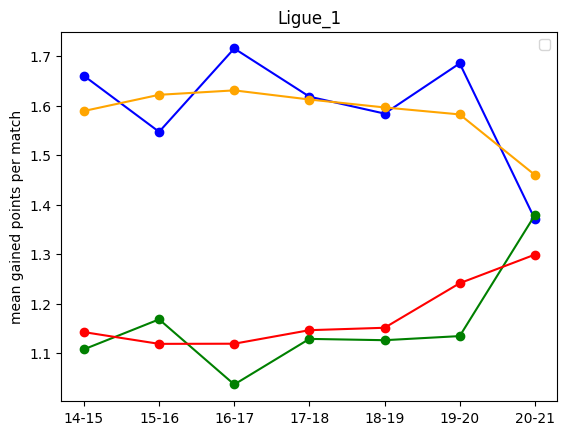

<ipython-input-28-368449f18510>:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_df = final_df._append({"Season": to_season[season], "result": getMeanPerYear(league, fixtures_dom), "xPoints" : getMeanXPointsPerYear(league, fixtures_dom), "result_away" : getMeanPerYear(league, fixtures_ext), "xPointsAway": getMeanXPointsPerYear(league, fixtures_ext)}, ignore_index=True)


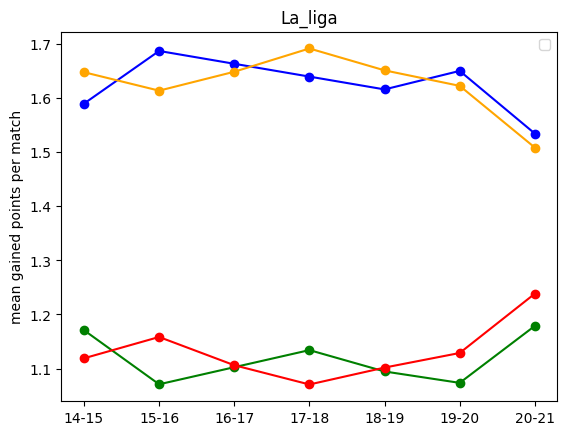

<ipython-input-28-368449f18510>:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_df = final_df._append({"Season": to_season[season], "result": getMeanPerYear(league, fixtures_dom), "xPoints" : getMeanXPointsPerYear(league, fixtures_dom), "result_away" : getMeanPerYear(league, fixtures_ext), "xPointsAway": getMeanXPointsPerYear(league, fixtures_ext)}, ignore_index=True)


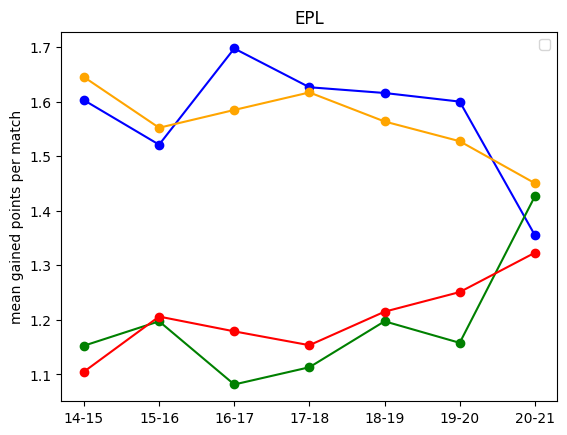

<ipython-input-28-368449f18510>:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_df = final_df._append({"Season": to_season[season], "result": getMeanPerYear(league, fixtures_dom), "xPoints" : getMeanXPointsPerYear(league, fixtures_dom), "result_away" : getMeanPerYear(league, fixtures_ext), "xPointsAway": getMeanXPointsPerYear(league, fixtures_ext)}, ignore_index=True)


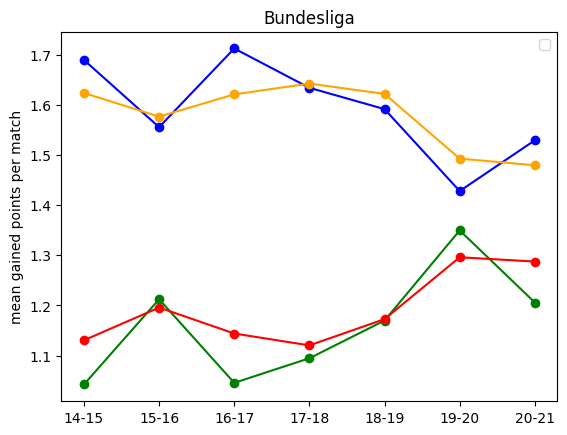

<ipython-input-28-368449f18510>:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_df = final_df._append({"Season": to_season[season], "result": getMeanPerYear(league, fixtures_dom), "xPoints" : getMeanXPointsPerYear(league, fixtures_dom), "result_away" : getMeanPerYear(league, fixtures_ext), "xPointsAway": getMeanXPointsPerYear(league, fixtures_ext)}, ignore_index=True)


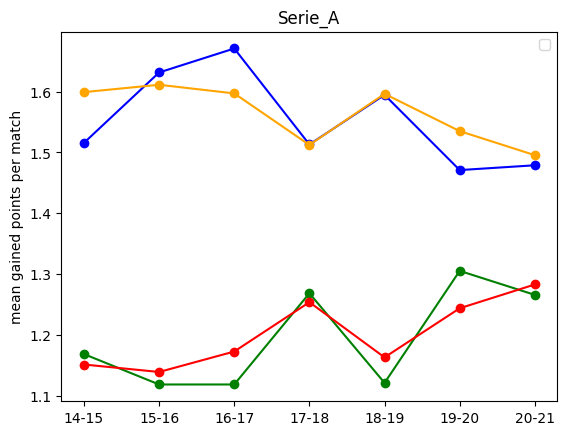

<ipython-input-28-368449f18510>:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_df = final_df._append({"Season": to_season[season], "result": getMeanPerYear(league, fixtures_dom), "xPoints" : getMeanXPointsPerYear(league, fixtures_dom), "result_away" : getMeanPerYear(league, fixtures_ext), "xPointsAway": getMeanXPointsPerYear(league, fixtures_ext)}, ignore_index=True)


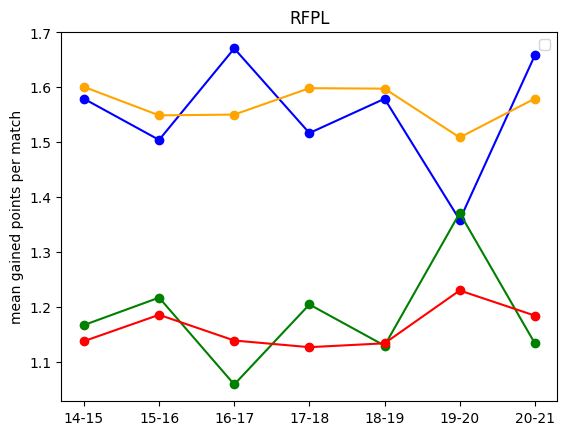

In [28]:

def getMeanPerYear(league, liste):
    num_array = np.array(liste)
    pandas_array = pd.DataFrame(num_array[1:], columns=num_array[0])
    totalPoints = getPoints(liste)
    total_team = pandas_array['Team'].count()
    total_matches = int(pandas_array.loc[0, 'M'])
    return totalPoints/(total_matches*total_team)

def getMeanXPointsPerYear(league, liste):
    num_array = np.array(liste)
    pandas_array = pd.DataFrame(num_array[1:], columns=num_array[0])
    totalPoints = getXPoints(liste)
    total_team = pandas_array['Team'].count()
    total_matches = int(pandas_array.loc[0, 'M'])
    return totalPoints/(total_matches*total_team)

to_season = {2014 : "14-15", 2015 : "15-16", 2016 : "16-17", 2017 : "17-18", 2018 : "18-19", 2019 : "19-20", 2020 : "20-21"}

async with aiohttp.ClientSession() as session:
  understat = Understat(session)
  for league in LEAGUES:
    final_df = pd.DataFrame(columns=["Season", "result", "xPoints", "result_away", "xPointsAway"])
    for season in SEASONS:
      fixtures_dom = await understat.get_league_table(league, season, h_a = "home")
      fixtures_ext = await understat.get_league_table(league, season, h_a = "away")
      final_df = final_df._append({"Season": to_season[season], "result": getMeanPerYear(league, fixtures_dom), "xPoints" : getMeanXPointsPerYear(league, fixtures_dom), "result_away" : getMeanPerYear(league, fixtures_ext), "xPointsAway": getMeanXPointsPerYear(league, fixtures_ext)}, ignore_index=True)
    plt.plot(final_df['Season'], final_df['result'], marker='o', color="blue")
    plt.plot(final_df['Season'], final_df['result_away'], marker='o', color="green")
    plt.plot(final_df['Season'], final_df['xPoints'], marker='o', color="orange")
    plt.plot(final_df['Season'], final_df['xPointsAway'], marker='o', color="red")
    plt.title(league)
    plt.ylabel("mean gained points per match")
    plt.legend()
    plt.show()


## REALLY ?

This parts aims at reproducing statistical tests from the original paper. Intuitively, the observations for COVID-like seasons might be due to “luck” and randomness (eg there were more victories away but it’s due to coincidence or low number of matches). We need to prove that those differences are not due to luck by comparing sample means with different kind of tests.

 We used the non-parametrical Wilcoxon Signed-Rank test to assess differences in means between home and away matches, considering either actual result, xPoints, or xG. The most important metrics here are the p-values calculated. The null hypothesis is that results at home come from the same distributions as results away. A p-value below 0.05 would mean that we reject this null hypothesis. A p-value over 0.05 would mean that we do not reject the null hypothesis so home and away results are significantly the same.

 We collected actual results, xPoints and xGoals data thanks to the Understat API. Actually, we built an array with all results away and home for the different metrics (actual results, xPoints, xGoals) and we performed Wilcoxon Signed-Rank test with those arrays. We also calculated Cohen's d in order to mesure effect size. Unlike a hypothesis test (like a Wilcoxon Signed-Rank test), which tells you if the difference is statistically significant, Cohen's d tells you how large the difference is in practical terms. The reading grid is as follows: small < 0.20 (highlighted in yellow), 0.20 <= medium < 0.50, 0.5 <= large < 0.8. Cohen's d test doesn't natively exist in Python and was not cleary detailed in the paper so we used the follwing pooled formula:

```
Cohen's d = sqrt(((n1 - 1)*s1^2 + (n2 - 1)*s2^2) / (n1 + n2 - 2))
```

with :
- \( n1 \) sample 1 size
- \( n2 \) sample 2 size
- \( s1 \) sample 1 standard derivation
- \( s2 \) sample 2 standard derivation


 We obtained the exact same figures for the Wilcoxon test and Cohen's d value for the actual results than in the original paper. This leads to the same observations as in the paper, p-values are especially high and cohen's d values are especially low for seasons impacted by Covid-19 (2019-2020 for some leagues and 2020-2021 for most of them). This shows that actual results obtained home and away are very similar when there was no public in stadiums.

 However, we obtained different results than the original paper regarding xPoints results. Results look similar but are not exactly the same in our reproduction here. Those small differences could be due to the way we retreived our data. We used the API to collect xPoints from each match of each season, home and away seperately, and created arrays to contain the results. We then applied the Wilcoxon test to compare home and away arrays. The exact protocol was not detailed and may have been different. Despite those differences, results obtained are showing similar patterns as the original one, with very low p-values for classical seasons and very high one for Covid seasons for most of the leagues. Like in the original paper, La Liga seems not impacted at all here. Cohen's d results are the exact same for xPoints than the original paper.

 Regarding xGoals results, we followed the same protocol than xPoints and actual results and obtained different results for the p-values but the exact same results for Cohen's d test. All leagues (except RFPL) seem to obtain very high p-values for xGoals during pandemic seasons than for classical seasons as well as lower Cohen's d values during pandemic seasons than for classical seasons. It means that teams are significantly scoring more goals when they are playing home than away except during pandemic seasons.

In [14]:

def getHomeAwayResultPerMatch(result, home, away):
  if result['h'] > result['a']:
    home.append(3)
    away.append(0)
  elif result['h'] < result['a']:
    home.append(0)
    away.append(3)
  else:
    home.append(1)
    away.append(1)

def getGoalsAwayHomePerMatch(result, home, away):
  home.append(result['h'])
  away.append(result['a'])

def getXPointsHomeAwayPerMatch(array, home, away):
  if array['h_a'] == 'h':
    home.append(array['xpts'])
  else :
    away.append(array['xpts'])

def cohen_d(home, away):
  mean_a = np.mean(home)
  mean_b = np.mean(away)
  std_a = np.std(home, ddof=1)
  std_b = np.std(away, ddof=1)

  n_a = len(home)
  n_b = len(away)

  s_p = np.sqrt(((n_a - 1) * std_a**2 + (n_b - 1) * std_b**2) / (n_a + n_b - 2))

  cohen_d = (mean_a - mean_b) / s_p
  return cohen_d

def wilcoxon_test(array, home, away):
  for i in range(len(array)):
    getHomeAwayResultPerMatch(array[i]['goals'], home, away)
  stat, p = wilcoxon(home, away)
  return stat, p

def wilcox_x_test(array, home, away):
  for i in range(len(array)):
    for j in range(len(array[i]["history"])):
      getXPointsHomeAwayPerMatch(array[i]["history"][j], home, away)
  stat, p = wilcoxon(home, away)
  return stat, p

def getGoalsAwayHomePerMatch(result, home, away):
  home.append(float(result['h']))
  away.append(float(result['a']))

def wilcoxon_xgoals_test(array, home, away):
  for i in range(len(array)):
    getGoalsAwayHomePerMatch(array[i]['xG'], home, away)
  stat, p = wilcoxon(home, away)
  return stat, p


final_df = pd.DataFrame(columns=["League", "Season", "wilco-result", "wilco-result-pvalue", "result-cohend"])

async with aiohttp.ClientSession() as session:
  understat = Understat(session)
  for league in LEAGUES:
    for season in SEASONS:
      home_results = []
      away_results = []
      home_xpoints = []
      away_xpoints = []
      home_xgoals = []
      away_xgoals = []
      fixtures = await understat.get_league_results(league, season)
      fixtures2 = await understat.get_teams(league, season)
      num_array = np.array(fixtures)
      wilco_test = wilcoxon_test(num_array, home_results, away_results)
      cohend_test = cohen_d(home_results, away_results)
      wilco_test_x = wilcox_x_test(fixtures2, home_xpoints, away_xpoints)
      cohend_test_x = cohen_d(home_xpoints, away_xpoints)
      wilco_test_xgoals = wilcoxon_xgoals_test(num_array, home_xgoals, away_xgoals)
      cohend_test_xgoals = cohen_d(home_xgoals, away_xgoals)
      new_row = pd.DataFrame({
          "League": [league],
          "Season": [season],
          "wilco-result": [wilco_test[0]],
          "wilco-result-pvalue": [round(wilco_test[1], 6)],
          "result-cohend": [cohend_test],
          "wilco-xPoints": [wilco_test_x[0]],
          "wilco-xPoints-pvalue": [round(wilco_test_x[1], 6)],
          "xPoints-cohend": [cohend_test_x],
          "wilco-xG": [wilco_test_xgoals[0]],
          "wilco-xG-pvalue": [round(wilco_test_xgoals[1], 6)],
          "xG-cohend": [cohend_test_xgoals],
      })
      final_df = pd.concat([final_df, new_row], ignore_index=True)

final_df

<ipython-input-14-4a3c48fe8410>:94: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_df = pd.concat([final_df, new_row], ignore_index=True)


,League,Season,wilco-result,wilco-result-pvalue,result-cohend,wilco-xPoints,wilco-xPoints-pvalue,xPoints-cohend,wilco-xG,wilco-xG-pvalue,xG-cohend
0,Ligue_1,2014,16261.5,0.000042,0.423654,19144.0,0.000000,0.592618,24379.0,0.000000,0.428402
1,Ligue_1,2015,15288.0,0.003609,0.296835,16363.5,0.000000,0.665501,23010.0,0.000000,0.484468
2,Ligue_1,2016,14350.0,0.000000,0.531954,17052.5,0.000000,0.676671,22658.0,0.000000,0.479961
3,Ligue_1,2017,15817.5,0.000234,0.378394,18828.5,0.000000,0.576631,24357.0,0.000000,0.439724
4,Ligue_1,2018,14363.0,0.000416,0.361783,19937.0,0.000000,0.578288,24923.0,0.000000,0.444494
5,Ligue_1,2019,7875.0,0.000045,0.495734,10871.0,0.000000,0.558692,13308.0,0.000006,0.440770
6,Ligue_1,2020,20306.0,0.952765,-0.005987,30973.0,0.014800,0.191954,32028.0,0.051795,0.190976
7,La_liga,2014,17110.0,0.001823,0.319278,16927.0,0.000000,0.620607,23934.0,0.000000,0.446100
8,La_liga,2015,15317.0,0.000008,0.464918,18922.0,0.000000,0.541456,25216.0,0.000000,0.435300
9,La_liga,2016,16060.0,0.000032,0.430693,16643.0,0.000000,0.673844,23064.0,0.000000,0.475527


We then used the non-parametrical Mann–Whitney U test to assess differences between seasons (in terms of actual results home and xPoints home). We did the test for each pair of season: for example, 2020 with 2014, 2020 with 2015, ... The idea is to compare COVID seasons with non-COVID seasons. We highlighted in red p-value < 0.05 and report only for xPoints.


We used the *mannwhitneyu* function from Scipy to perform the tests. It was not mentioned in the paper whether the test needed to be perfomed with the *greater*, *lower* or *two-sided* option. We decided to perform it with the *greater* option because we wanted to check whether the values from group 1 were significantly higher than group 2. It aims at comparing precisely if classical seasons xPoints earned at home are higher than for pandemic seasons. A below 0.05 p-value would mean we consider that the xPoints won during a given classical season are significantly higher than during a pandemic season.

We obtained similar results than in the original paper with slight differences for some pairs. It could be explained by a difference in the used formula or because we used a different option for the alternative hypothesis. However, results obtained here lead to the same conclusions as the original paper. Values highlighted in red (p-values lower than 0.05) are the exact same here and in the paper.

Statistical results over xPoints show that the COVID has impacted the usual and relative home advantage within all leagues (except Russia).


In [16]:

def getXPointsHomeAwayPerMatch(array, home):
  if array['h_a'] == 'h':
    home.append(array['xpts'])

def mannwhitneyutest(season1, season2):
  stat, p_value = mannwhitneyu(season1, season2, alternative="greater")
  return stat, p_value

def getMeanPerYear(league, liste):
    num_array = np.array(liste)
    pandas_array = pd.DataFrame(num_array[1:], columns=num_array[0])

SEASONS = [2014, 2015, 2016, 2017, 2018, 2019, 2020]
LEAGUES = ["Ligue_1", "La_liga", "EPL", "Bundesliga", "Serie_A", "RFPL"]
tableaux = {}
for league in LEAGUES :
  tableaux[league] = pd.DataFrame(index = SEASONS, columns = SEASONS)

async with aiohttp.ClientSession() as session:
  understat = Understat(session)
  for league in LEAGUES:
    season = 2014
    while season <= 2020:
      season1 = []
      fixtures = await understat.get_teams(league, season)
      num_array = np.array(fixtures)
      for i in range(len(num_array)):
        for j in range(len(num_array[i]["history"])):
          getXPointsHomeAwayPerMatch(num_array[i]["history"][j], season1)
      other_season = season + 1
      while other_season <= 2020:
        season2 = []
        fixtures2 = await understat.get_teams(league, other_season)
        num_array2 = np.array(fixtures2)
        for i in range(len(num_array2)):
          for j in range(len(num_array2[i]["history"])):
            getXPointsHomeAwayPerMatch(num_array2[i]["history"][j], season2)
        _, p = mannwhitneyutest(season1, season2)
        tableaux[league].loc[other_season, season] = float(p)
        other_season += 1
      season += 1



In [24]:
from IPython.display import display
def color_red_if_below(value):
    if value == '':
      return 'color: white'
    color = 'red' if value < 0.05 else 'white'
    return f'color: {color}'

for league in LEAGUES:
  tableau = tableaux[league].fillna('')
  tableau_styled = tableau.style.applymap(color_red_if_below)
  print(f'{league} xPoints change significance with mann')
  display(tableau_styled)
  print('\n')


Ligue_1 xPoints change significance with mann


<ipython-input-24-faa712604c99>:10: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  tableau_styled = tableau.style.applymap(color_red_if_below)


,2014,2015,2016,2017,2018,2019,2020
2014,,,,,,,
2015,0.748413,,,,,,
2016,0.793004,0.551731,,,,,
2017,0.678840,0.486951,0.416316,,,,
2018,0.539813,0.307324,0.263694,0.357313,,,
2019,0.475235,0.281316,0.229452,0.329968,0.452696,,
2020,0.012860,0.003026,0.001610,0.005677,0.010800,0.022473,




La_liga xPoints change significance with mann


,2014,2015,2016,2017,2018,2019,2020
2014,,,,,,,
2015,0.296950,,,,,,
2016,0.463205,0.694358,,,,,
2017,0.695632,0.875537,0.737869,,,,
2018,0.401489,0.688950,0.435032,0.204784,,,
2019,0.280083,0.500725,0.294325,0.116348,0.339354,,
2020,0.010252,0.041088,0.010438,0.001273,0.009941,0.030452,




EPL xPoints change significance with mann


,2014,2015,2016,2017,2018,2019,2020
2014,,,,,,,
2015,0.061527,,,,,,
2016,0.207232,0.740607,,,,,
2017,0.408597,0.880683,0.708629,,,,
2018,0.104277,0.582330,0.392697,0.208510,,,
2019,0.032631,0.374404,0.193936,0.077760,0.259500,,
2020,0.000771,0.047840,0.015727,0.003932,0.032861,0.102317,




Bundesliga xPoints change significance with mann


,2014,2015,2016,2017,2018,2019,2020
2014,,,,,,,
2015,0.231447,,,,,,
2016,0.501550,0.736870,,,,,
2017,0.667161,0.840840,0.610721,,,,
2018,0.592814,0.774432,0.549850,0.436968,,,
2019,0.028356,0.112950,0.032958,0.017482,0.037053,,
2020,0.013052,0.074474,0.015019,0.006203,0.017463,0.423587,




Serie_A xPoints change significance with mann


,2014,2015,2016,2017,2018,2019,2020
2014,,,,,,,
2015,0.619318,,,,,,
2016,0.507712,0.420963,,,,,
2017,0.071788,0.050205,0.090418,,,,
2018,0.507448,0.362505,0.474771,0.921274,,,
2019,0.144887,0.107633,0.150452,0.647853,0.164695,,
2020,0.050377,0.032081,0.049695,0.389018,0.058381,0.268684,




RFPL xPoints change significance with mann


,2014,2015,2016,2017,2018,2019,2020
2014,,,,,,,
2015,0.244360,,,,,,
2016,0.241067,0.492911,,,,,
2017,0.477957,0.761795,0.753569,,,,
2018,0.480448,0.754295,0.758317,0.489368,,,
2019,0.092400,0.269055,0.249973,0.082672,0.083882,,
2020,0.401769,0.671920,0.666552,0.444909,0.459114,0.837740,


## CONCLUSION

The next objective of this project will be to replicate the paper by modifying some parameters and to defining a protocol to make a variation of the original study, including what and how to vary, the hypothesis and expected results.
